# TASK 4: Idea <br>
1) Simply train CONV auto encoder for sparse feature representations which we take from the encoded layer after training. Objective is to downsample to create features and upsample to recreate same image. Since image, so use CONV layers. <br>

2) Then take encoded features to train a simple Multi-class MLP <br>
3) Prediction and Confusion matrices are trivial stuff afterwards <br>



##### 7 Segment Display - Point to Note
Note that the 7 segment display is taken from geeksforgeeks website as given in comments below. Displays are clockwise with middle one last.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define seven-segment mappings for digits 0-9
# This is taken from https://www.geeksforgeeks.org/seven-segment-displays/
# They have an intuitive mapping with images. Easy to verify.
# Also the assignment had werid example of 0 in the problem statement. Everything was 1's whereas all 1's indicate number 8, not 0.
# So using this instead.
seven_segment_mappings = {
    0: [1, 1, 1, 1, 1, 1, 0],  # 0
    1: [0, 1, 1, 0, 0, 0, 0],  # 1
    2: [1, 1, 0, 1, 1, 0, 1],  # 2
    3: [1, 1, 1, 1, 0, 0, 1],  # 3
    4: [0, 1, 1, 0, 0, 1, 1],  # 4
    5: [1, 0, 1, 1, 0, 1, 1],  # 5
    6: [1, 0, 1, 1, 1, 1, 1],  # 6
    7: [1, 1, 1, 0, 0, 0, 0],  # 7
    8: [1, 1, 1, 1, 1, 1, 1],  # 8
    9: [1, 1, 1, 1, 0, 1, 1]   # 9
}

## Training CONV Auto Encoder
val_loss decreasing slowly at the end, don't need more epochs <br>
Reshaping input data is necessary

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data for convolutional layers
# This step is very important because Reshaping is needed for CONV layers
# Withput this get this error ---> ValueError: Dimensions must be equal
input_shape = (28, 28, 1)
x_train = np.reshape(x_train, (len(x_train), *input_shape))
x_test = np.reshape(x_test, (len(x_test), *input_shape))

# Create seven-segment labels
y_seven_segment_train = np.array([seven_segment_mappings[digit] for digit in y_train])
y_seven_segment_test = np.array([seven_segment_mappings[digit] for digit in y_test])

# Build the Convolutional Autoencoder
latent_dim = 32  # Reduced dimensionality

# Encoder
input_img = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
encoded = MaxPooling2D((2, 2), padding='same')(conv2)

# Decoder
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
up1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1906 - val_loss: 0.0727
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0725 - val_loss: 0.0694
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0698 - val_loss: 0.0679
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0684 - val_loss: 0.0670
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0672 - val_loss: 0.0662
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0665 - val_loss: 0.0656
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0660 - val_loss: 0.0652
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0655 - val_loss: 0.0649
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0652 - val_loss: 0.0645
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0647 - val_loss: 0.0644
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0647 - val_loss: 0.0640
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

## Building MLP
Note that val_loss is lowest at 17 epochs. Since we are training for just 20 epochs it's fine and no significant need to use a callback and use best val_loss checkpoint as the final accuracy is also good.

In [3]:
# Build the encoder model to extract features
encoder = Model(input_img, encoded)

# Extract features from the training and testing data
encoded_input_shape = encoder.output_shape[1:]
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Flatten the encoded features for the MLP
x_train_features = x_train_encoded.reshape(x_train_encoded.shape[0], -1)
x_test_features = x_test_encoded.reshape(x_test_encoded.shape[0], -1)

# Build the MLP classifier
mlp_input_shape = x_train_features.shape[1]
mlp_output_shape = 7

mlp_input = Input(shape=(mlp_input_shape,))
dense1 = Dense(128, activation='relu')(mlp_input)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(mlp_output_shape, activation='sigmoid')(dense2) # Sigmoid for multi-label

mlp_classifier = Model(mlp_input, output_layer)

# Compile the MLP classifier
mlp_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])

# Train the MLP classifier
mlp_classifier.fit(x_train_features, y_seven_segment_train,
                   epochs=20,
                   batch_size=128,
                   shuffle=True,
                   validation_split=0.2)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2439 - val_loss: 0.0745
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0640 - val_loss: 0.0498
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0447 - val_loss: 0.0328
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0347 - val_loss: 0.0342
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0240
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0227 - val_loss: 0.0278
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0239
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0251
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0256
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

# Good overall accuracy of 97% and confusion matrices look good

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


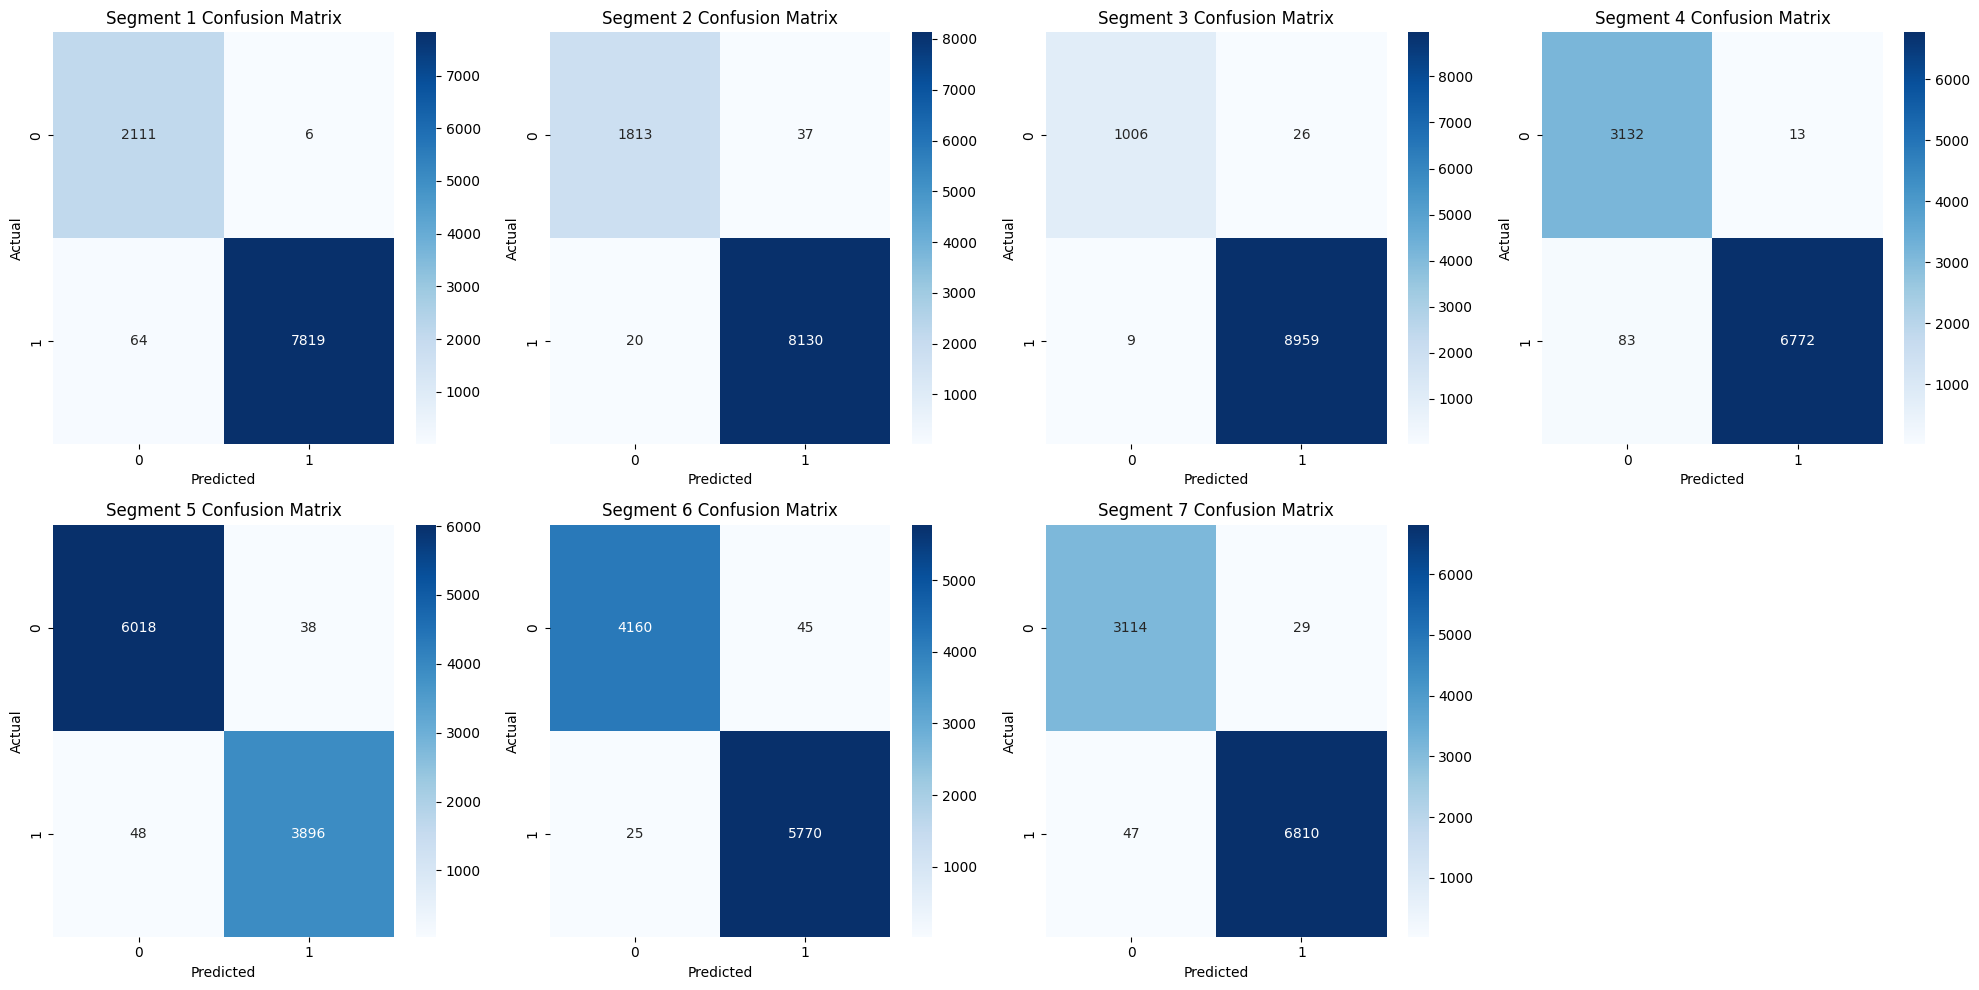

Overall Accuracy: 0.9722


In [6]:
# Make predictions on the test set
predictions = mlp_classifier.predict(x_test_features)

# Threshold the predictions to get binary outputs (0 or 1 for each segment)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the confusion matrix for each segment
confusion_matrices = []
for i in range(mlp_output_shape):
    cm = confusion_matrix(y_seven_segment_test[:, i], binary_predictions[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten the 2D array to 1D for easier indexing

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'],
                ax=axes[i])
    axes[i].set_title(f'Segment {i+1} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the last subplot (since we only have 7 matrices)
axes[-1].remove()

plt.tight_layout()
plt.show()

# Calculate overall accuracy (you can define this differently based on your needs)
correct_predictions = np.all(binary_predictions == y_seven_segment_test, axis=1)
overall_accuracy = np.mean(correct_predictions)
print(f"Overall Accuracy: {overall_accuracy:.4f}")